In [492]:
import pandas as pd
import seaborn as sn
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn import model_selection as ms
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.metrics import mean_squared_error

# Exploratory Data Analysis

For this assignment, I am using the Recurrrent Neural Network models to predict the price of stocks. I am using the stock price of Nike, Inc. from 2006-2018 as a dataset.

Link to dataset - https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?select=NKE_2006-01-01_to_2018-01-01.csv


In [493]:
#reading in dataset
df = pd.read_csv("./NKE_2006-01-01_to_2018-01-01.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.85,10.92,10.67,10.74,18468800,NKE
1,2006-01-04,10.71,10.80,10.67,10.69,15832000,NKE
2,2006-01-05,10.69,10.83,10.69,10.76,9256000,NKE
3,2006-01-06,10.79,10.83,10.71,10.72,7573600,NKE
4,2006-01-09,10.72,10.98,10.72,10.88,10441600,NKE


In [494]:
#removing name column (just 1 stock)
df.drop(["Name"], axis = 1, inplace= True)
rows, cols = df.shape
print("There are {} rows".format(rows))
print("There are {} columns".format(cols))

There are 3020 rows
There are 6 columns


In [495]:
df.isna().sum()

Date      0
Open      1
High      0
Low       0
Close     0
Volume    0
dtype: int64

There is 1 row which has an null value. Since removing this would not affect the dataset in a significant way, the row with the null value is removed.

In [496]:
df = df.dropna()
df.shape

(3019, 6)

In [497]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019 entries, 0 to 3019
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [498]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,29.893114,30.172607,29.621504,29.907327,1.136796e+07
std,17.191774,17.306240,17.067344,17.190235,6.851845e+06
min,9.560000,9.600000,9.440000,9.520000,8.338860e+05
25%,15.110000,15.375000,14.885000,15.150000,7.214992e+06
50%,23.580000,23.850000,23.340000,23.520000,9.605016e+06
75%,47.680000,48.010000,47.280000,47.690000,1.353157e+07
max,68.120000,68.200000,66.670000,67.160000,8.637798e+07


In [499]:
#Date is expanded to separate columns for more analysis
df[["Year", "Month", "Day"]] = df["Date"].str.split("-", expand = True)
#Converting date to datetime for preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day
0,2006-01-03,10.85,10.92,10.67,10.74,18468800,2006,01,03
1,2006-01-04,10.71,10.80,10.67,10.69,15832000,2006,01,04
2,2006-01-05,10.69,10.83,10.69,10.76,9256000,2006,01,05
3,2006-01-06,10.79,10.83,10.71,10.72,7573600,2006,01,06
4,2006-01-09,10.72,10.98,10.72,10.88,10441600,2006,01,09


In [500]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Year              object
Month             object
Day               object
dtype: object

The below plots display a "zoomed-in" view of the Nike Stock price for each year from 2006-2018 rather than the entire time period. This gives a better feel of how the stock performed in each year.

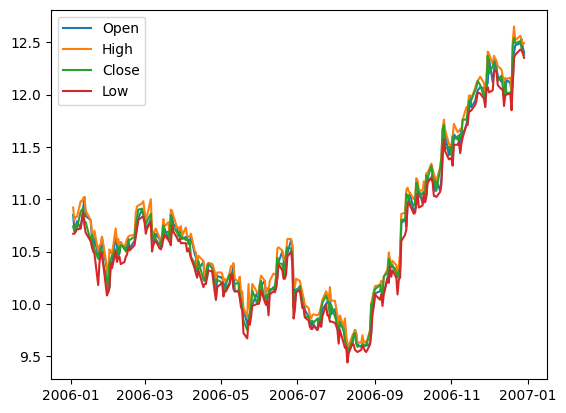

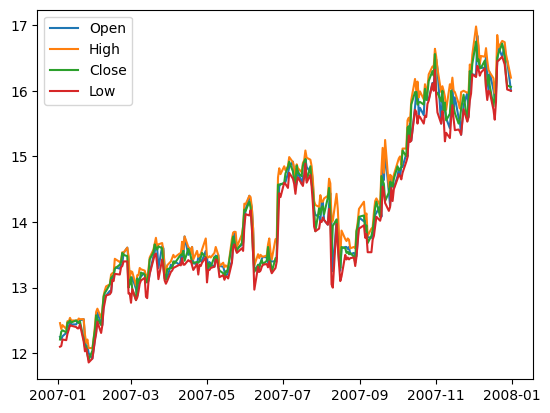

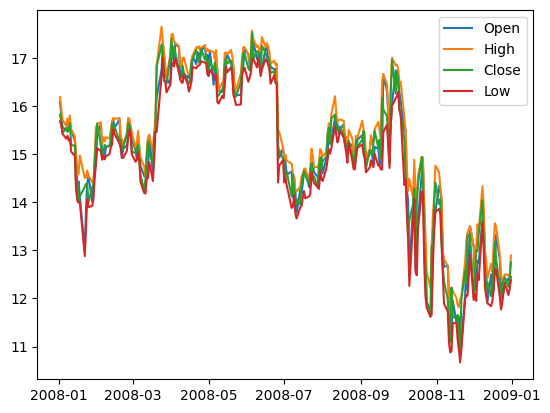

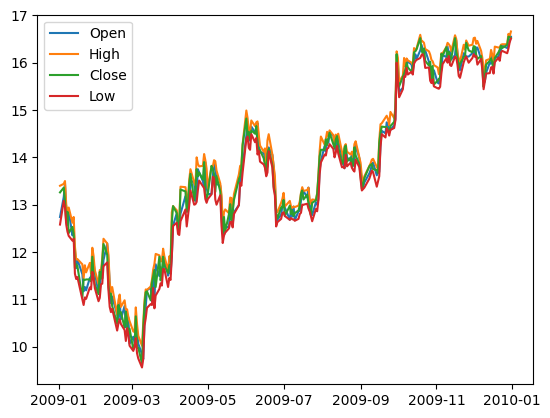

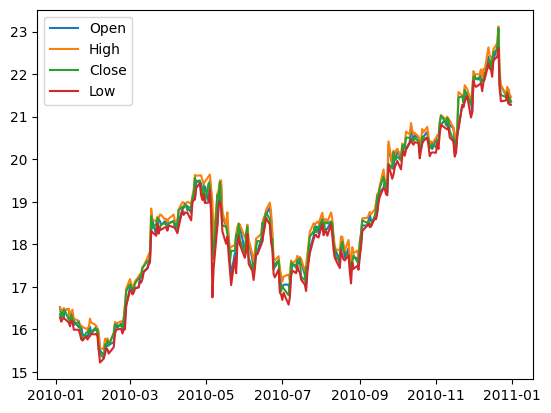

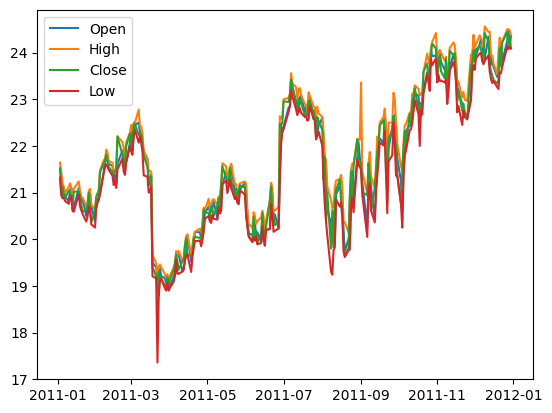

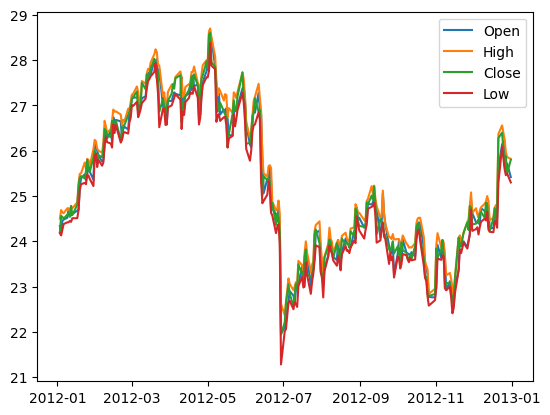

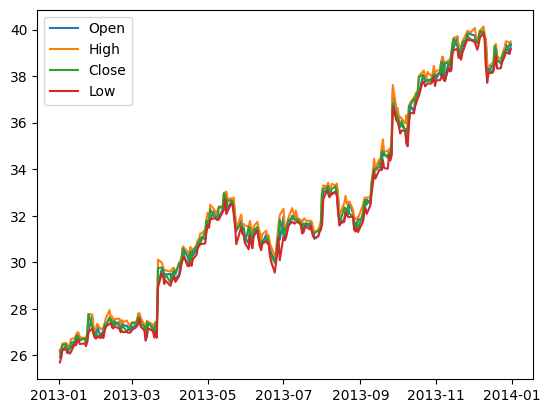

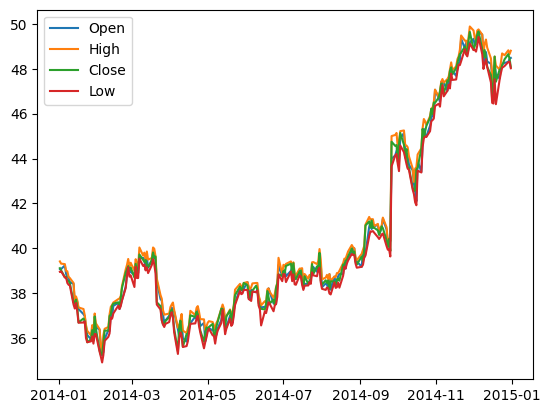

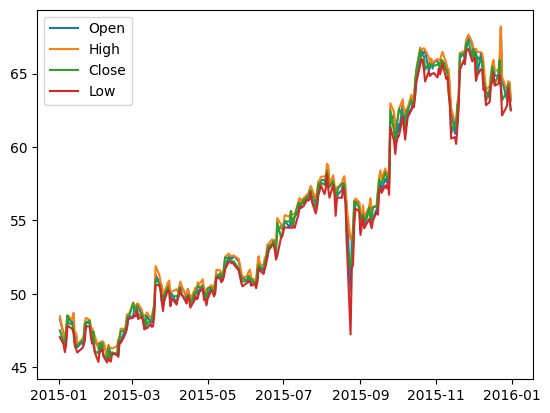

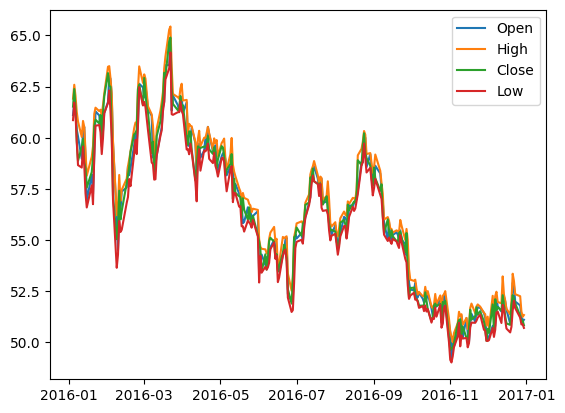

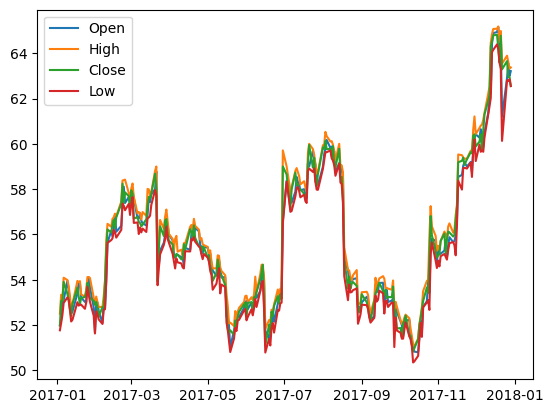

In [501]:
for year in range(2006,2018):
    df_year = df[df["Year"] == str(year)]

    plt.plot(df_year["Date"], df_year["Open"], label = "Open")
    plt.plot(df_year["Date"], df_year["High"], label = "High")
    plt.plot(df_year["Date"], df_year["Close"], label = "Close")
    plt.plot(df_year["Date"], df_year["Low"], label = "Low")
    plt.legend()
    plt.show()

<AxesSubplot:xlabel='Date'>

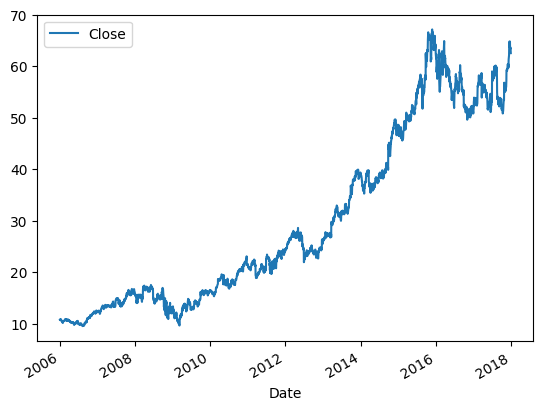

In [502]:
df.plot(x='Date',y='Close')

# Feature Pre-Processing for RNN
For this assignment, the RNN will just be focusing on predicting the Close price of NIKE stock

In [503]:
dataset = df.filter(["Date", "Close"])
dataset.head()


,Date,Close
0,2006-01-03,10.74
1,2006-01-04,10.69
2,2006-01-05,10.76
3,2006-01-06,10.72
4,2006-01-09,10.88


In [504]:
#Split dataset into train and test
split_ratio = 0.9
train_len = round(dataset.shape[0] * split_ratio)
train_data = dataset[:train_len]
test_data = dataset[train_len:]


In [505]:
#Normalizing training set values
train_set_X = train_data.Close.values
train_set_X = np.reshape(train_set_X, (-1, 1))
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train_set_X)


#Normalizing test set values
test_set_X = test_data.Close.values
test_set_X = test_set_X.reshape(-1, 1)
test_scaled = sc.transform(test_set_X)

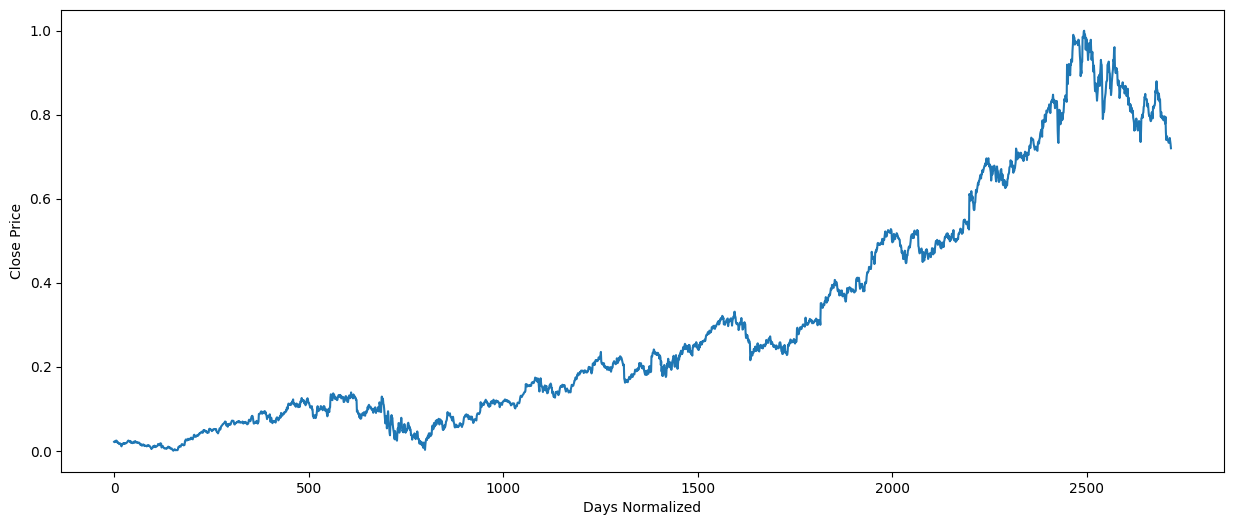

In [506]:
#Visualzing normalized data to ensure consistency
plt.subplots(figsize = (15,6))
plt.plot(train_scaled)
plt.xlabel("Days Normalized")
plt.ylabel("Close Price")
plt.show()

The function below creates 3-dimensional datasets for both the training and test sets so that they can be input in the RNN model. The sets are created in a way such that all the observations for a certain range correspond with one output.

In [507]:
def gen_3D_dataset(data, step):
	X_data, Y_data = [], []
	for i in range(len(data)-step-1):
		temp = dataset[i:(i+step), 0]
		X_data.append(temp)
		Y_data.append(dataset[i + step, 0])

	X_data, Y_data = np.array(X_data), np.array(Y_data)
	X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1],1))
	Y_data = np.reshape(Y_data, (Y_data.shape[0],1))
	return X_data, Y_data

In [508]:
#Creates 3-D Training Set
X_train, Y_train = create_dataset(train_scaled, 14)
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train:",Y_train.shape)

Shape of X_train:  (2702, 14, 1)
Shape of y_train: (2702, 1)


In [509]:
#Creates 3-D Test Set
X_test, Y_test = create_dataset(test_scaled, 14)
print("Shape of X_train: ",X_test.shape)
print("Shape of y_train:",Y_test.shape)

Shape of X_train:  (287, 14, 1)
Shape of y_train: (287, 1)


# Part 1: Simple RNN
Below is a function to create an RNN using the Keras framework from Tensorflow. The function generates 3 types of models based on the input (Simple, LSTM, GRU). There is one input layer which returns the sequences and then another hidden layer, and then a dense output layer. The model also includes Dropout regularization after each layer to help prevent overfitting.

In [510]:
def create_RNN(input_shape, output_shape, model_type):
    model = Sequential()
    if(model_type == "simple"):
        model.add(SimpleRNN(units = 128, activation = "relu", return_sequences = True, input_shape = input_shape))
    elif(model_type == "LSTM"):
            model.add(LSTM(units = 128, activation = "relu", return_sequences = True, input_shape = input_shape))
    elif(model_type == "GRU"):
            model.add(GRU(units = 128, activation = "relu", return_sequences = True, input_shape = input_shape))

    model.add(Dropout(0.2))
    if(model_type == "simple"):
        model.add(SimpleRNN(units =64, activation = "relu"))
    elif(model_type == "LSTM"):
            model.add(LSTM(units =64, activation = "relu"))
    elif(model_type == "GRU"):
            model.add(GRU(units =64, activation = "relu"))

    model.add(Dropout(0.2))
    model.add(Dense(units = 1))

    model.compile(optimizer='adam', loss='mse', metrics = ["mse"])
    model.summary()
    return model



The function below tests the model by plotting the training and validation losses. It also generates predictions on the test set and calculates the mean squared error as relating to the actual test set.

The metric used to compare the modesl is Mean Squared Error, which is the squared difference between the actual stock value and the predicted stock value generated by the model. This metric was selected since it is a very common metric to evaluate sequence to sequence and regression models. Furthermore, MSE magnifies large errors, which is helpful for a target variable such as stock price since the precision of the price is incredibly important.

In [511]:
def test_model(model, test):
    history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()

    prediction = model.predict(X_test)
    prediction = sc.inverse_transform(prediction)

    error = mean_squared_error(test, prediction)
    rmse = mean_squared_error(test, prediction)**0.5
    print('Test MSE: %.3f' % rmse)

    return prediction

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_49 (SimpleRNN)   (None, 14, 128)           16640     
                                                                 
 dropout_56 (Dropout)        (None, 14, 128)           0         
                                                                 
 simple_rnn_50 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dropout_57 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
68/68 [==============================]

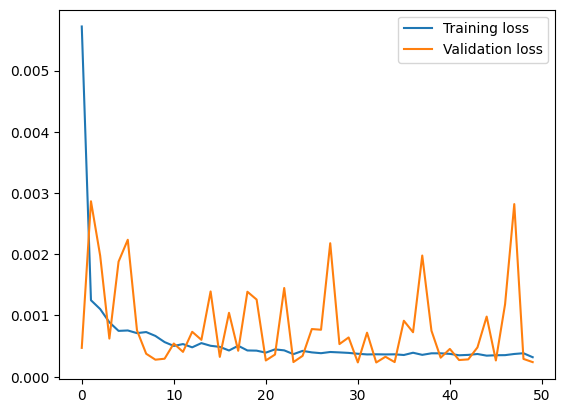

In [512]:
#Creating, fitting, and evaluating Simple RNN Model
simple_model = create_RNN( (X_train.shape[1], X_train.shape[2]), Y_train.shape[1], "simple")
simple_pred = test_model(simple_model, sc.inverse_transform(Y_test))

# Part 2: LSTM and GRU

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 14, 128)           66560     
                                                                 
 dropout_58 (Dropout)        (None, 14, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_59 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
68/68 [=============================

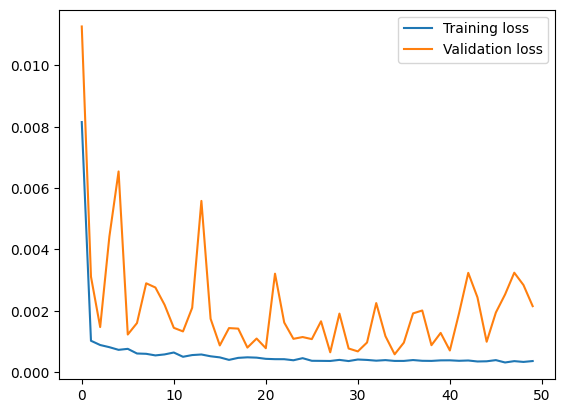

In [513]:
#Creating, fitting, and evaluating LSTM RNN Model
lstm_model = create_RNN((X_train.shape[1], X_train.shape[2]), Y_train.shape[1], "LSTM")
lstm_pred = test_model(lstm_model, sc.inverse_transform(Y_test))

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 14, 128)           50304     
                                                                 
 dropout_60 (Dropout)        (None, 14, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_61 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 87,617
Trainable params: 87,617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
68/68 [==============================]

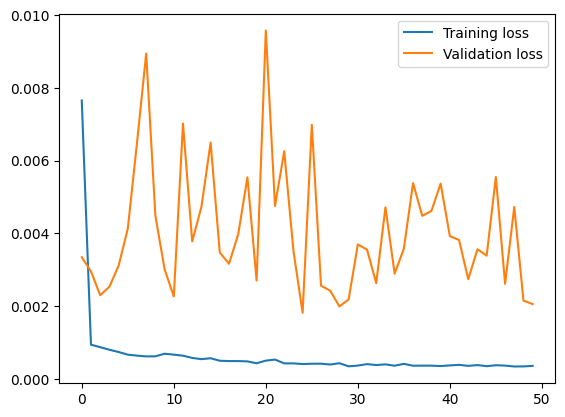

In [514]:
#Creating, fitting, and evaluating GRU RNN Model
gru_model = create_RNN((X_train.shape[1], X_train.shape[2]), Y_train.shape[1], "GRU")
gru_pred = test_model(gru_model, sc.inverse_transform(Y_test))

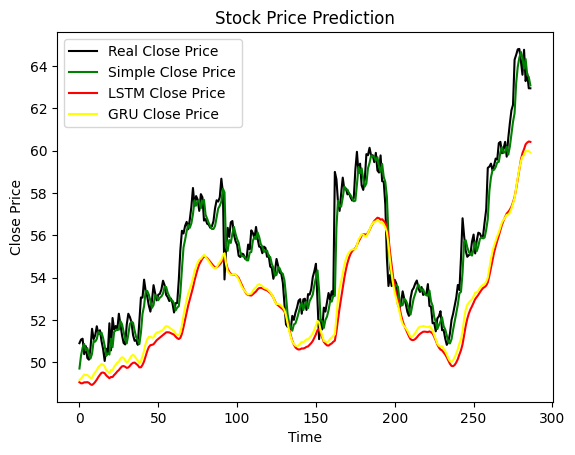

In [515]:
#Plotting the predictions of all the models vs the real output
plt.plot(sc.inverse_transform(Y_test), color = 'black', label = 'Real Close Price')
plt.plot(simple_pred, color = 'green', label = 'Simple Close Price')
plt.plot(lstm_pred, color = 'red', label = 'LSTM Close Price')
plt.plot(gru_pred, color = 'yellow', label = 'GRU Close Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Evaluation Results:
Simple RNN MSE: 1.811
LSTM RNN MSE: 1.851
GRU RNN MSE: 3.157

After calculating the MSE for each of the models, the Simple and LSTM have very similar MSEs, while the GRU model has a slightly higher MSE. In general, the MSE of all 3 models are very low (close to 0) which means that they are high performing.

As seen in the above plot, all 3 models fare very well in estimating the close prices of the test set. Therefore, there is no significant improvement in using the LSTM and GRU vs using the simple model. One reason for the high similarity is that LSTM and GRU achieve higher performance over a Simple RNN when there is a need for learning long term dependencies. While this dataset includes stock price over 12 years, there might not be a significant amount of long term dependencies which need to be learned to achieve better performance using the more complicated models. Also, there might not be a vanishing gradient problem with the simple model, so there is similar performance with LSTM and GRU models.

# Part 3

A traditional feed-forward network would not be able to solve this problem because of the need for learning long term dependencies. This dataset includes stock data from 2006-2018, with significant changes across the time series. A traditional feed forward network would only learn some part of the series patterns, but not over a long term which is needed for solving a task like stock prediction, which can have trends which go over the course of years.


# Task 2: Word Embeddings

In [516]:
#Uses GLOVE pretrained word embeddings and created dictionary of words and vector values
embeddings = {}
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as g_file:
    for line in g_file:
        vals = line.split()
        word = vals[0]
        vector = np.asarray(vals[1:], "float32")
        embeddings[word] = vector

Below are implementations for cosine similarity and dissimilarity for the pre-trained word embeddings. Cosine similarity is the dot product of the 2 word vectors divided by the norms of each vector. If 2 words have a cosine similarity score of close to 1, then they can be assumed to be the same word.

The dissimilarity score measure I chose was Euclidean Distance. THis is used to calculate word movers distance to determine document dissimilarity, so using it for word similarity is also applicable. If dissimilarity = 0, then then words are highly similar (same word). The greater the dissimilarity score is, the more dissimilar the words are.
https://medium.com/@nihitextra/word-movers-distance-for-text-similarity-7492aeca71b0 - WMD link

In [517]:
#cosine score using dot products and norms
def cosine_score(w1, w2, embeddings):
    #if word in pre-trained embeddings
    if(w1 in embeddings.keys() and w2 in embeddings.keys()):
        w1 = np.array(embeddings[w1])
        w2 = np.array(embeddings[w2])
        dot_product = w1.dot(w2)
        w1_norm = np.linalg.norm(w1)
        w2_norm = np.linalg.norm(w2)
        cos = dot_product/(w1_norm * w2_norm)
        return cos
    return None

#dissimilarity score using Euclidean distance
def dissimilarity(w1, w2, embeddings):
    #if word in pre-trained embeddings
    if(w1 in embeddings.keys() and w2 in embeddings.keys()):
        w1_v = embeddings[w1]
        w2_v = embeddings[w2]
        sub = w1_v - w2_v
        sum_sq = np.dot(sub.T, sub)
        return np.sqrt(sum_sq)

    return None
    



In [518]:
#examples of user input for both score metrics
print(cosine_score("the","ash", embeddings))
print(cosine_score("the","the", embeddings))
print(cosine_score("the","great", embeddings))

print(dissimilarity("the", "ash", embeddings))
print(dissimilarity("the", "the", embeddings))
print(dissimilarity("the","great", embeddings))

0.2732785
0.99999994
0.7252852
5.883107
0.0
3.83154
